## Capstone Task 3 - Statistical Analysis Code 

# Part I - Probability

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
#Reading in 
df = pd.read_csv('ab_data.csv')
df.head()

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

In [3]:
# number of rows in the dataset.
len(df)

294478

In [4]:
# The number of unique users in the dataset.
df.user_id.nunique()

290584

In [5]:
# The proportion of users converted.
df.converted.sum() /len(df)

0.11965919355605512

In [6]:
# The number of times when the "group" is treatment but "landing_page" is not a new_page.
len(df.query("group == 'treatment' and landing_page != 'new_page'"))

1965

In [7]:
# Rows with missing values
df.isnull().sum().sum()

0

## Dropping mismatched data

In [8]:
# Creating variables to hold df queries for better reading
drop_data_1 = df.query("group == 'control' and landing_page == 'new_page'")
drop_data_2 = df.query("group == 'treatment' and landing_page == 'old_page'")

#Dropping rows that contain a control group and a new page or a treatment group and a old page
df2 = df.drop(drop_data_1.index | drop_data_2.index)

#Confirming that these items no longer exist
df2.groupby(['group', 'landing_page'])['landing_page'].count()

group      landing_page
control    old_page        145274
treatment  new_page        145311
Name: landing_page, dtype: int64

In [9]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of both the statements below should be 0
#Double checking for both that these items no longer exist in a different way
print(df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0])
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]

0


0

In [10]:
# How many unique user_ids are in df2?
df2['user_id'].nunique()

290584

In [11]:
# Are there any repeated users? 
print("The duplicated user is:\n")
print(df2[df2.user_id.duplicated()])

The duplicated user is:

      user_id                   timestamp      group landing_page  converted
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


In [12]:
# Showing rows for repeated users
df2.query('user_id == 773192')

user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0

In [13]:
#Removing one of the repeated records

#Check number of rows
print(f"before removal: {df2.shape[0]}")
# Remove one of the rows with a duplicate user_id..
df2.drop(1899, inplace=True)
# Check again if the row with a duplicate user_id is deleted or not
print(f"after removal: {df2.shape[0]}")
df2.query('user_id == 773192')



before removal: 290585
after removal: 290584


user_id                   timestamp      group landing_page  converted
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0

In [14]:
# What is the probability of an individual converting regardless of the page they receive?
df2.converted.sum() / len(df2)

0.11959708724499628

In [15]:
# Given that an individual was in the control group, what is the probability they converted?
control_coversion_rate = df2.query("group == 'control'")['converted'].sum() / len(df2.query("group == 'control'"))
control_coversion_rate

0.1203863045004612

In [16]:
# Given that an individual was in the treatment group, what is the probability they converted?
treatment_coversion_rate = df2.query("group == 'treatment'")['converted'].sum() / len(df2.query("group == 'treatment'"))
treatment_coversion_rate

0.11880806551510564

In [17]:
# How much better or worse in the new landing page compared to the legacy landing page?
difference_in_conversion_rates = treatment_coversion_rate - control_coversion_rate
difference_in_conversion_rates

-0.0015782389853555567

In [18]:
# What is the probability that an individual received the new page?
len(df2.query("landing_page == 'new_page'")) / len(df2)

0.5000619442226688

### Probability test insights:
- After reviewing the data points explored above, there is no significant positive correlation between the treatment group and the number of conversions. 
- The data shows that the probability of conversion for the treatment group is in reality slightly lower than the probability of conversion for the control group. 
- This is a resounding negative result as the treatment group also had a slight edge on the percentage of individuals that would view that page. 

# Part 2 - A/B Test

- Null hypothesis: Pnew - Pold is equal to or less than 0
- Alternative hypothesis: Pnew - Pold > 0

Additional Info: 
- Due to the Type 1 error rate being 5% or 0.05, it will be necesary to observe a P value that is less than 5% in order to safely consider rejecting the null hypothesis. 
- If the P value for the data is above 5% or 0.05, then it will safe to consider that the data failed to reject the null hypothesis ergo making the alternate hypothesis more likely.

In [19]:
# What is the conversion rate for 𝑝𝑛𝑒𝑤 under the null hypothesis? 
P_new = df2.converted.mean()
P_new

0.11959708724499628

In [20]:
# What is the conversion rate for 𝑝𝑜𝑙𝑑 under the null hypothesis? 
P_old = df2.converted.mean()
P_old

0.11959708724499628

In [21]:
# What is 𝑛𝑛𝑒𝑤, the number of individuals in the treatment group? 
N_new = len(df2.query('landing_page == "new_page"'))
N_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [22]:
# What is 𝑛𝑜𝑙𝑑, the number of individuals in the control group?
N_old = len(df2.query('landing_page == "old_page"'))
N_old

145274

In [23]:
# Using numpy.random.choice() method to randomly generate 𝑛𝑛𝑒𝑤 number of values. 
new_page_converted = np.random.choice(2, size=N_new ,p=[P_new,1 - P_new])
#Every time this code is run the mean will change do to a new random sampling of the mean of values 0 or 1 N_new times.
new_page_mean = new_page_converted.sum() / len(new_page_converted)

In [24]:
# Simulating 𝑛𝑜𝑙𝑑 transactions with a conversion rate of 𝑝𝑜𝑙𝑑 under the null hypothesis.
old_page_converted = np.random.choice(2, size=N_old ,p=[P_old,1 - P_old])
#Every time this code is run the mean will change do to a new random sampling of the mean of values 0 or 1 N_new times.
old_page_mean = old_page_converted.sum() / len(old_page_converted)

In [25]:
# Finding the difference in the "converted" probability (𝑝′𝑛𝑒𝑤 - 𝑝′𝑜𝑙𝑑) for your simulated samples from the parts (e) and (f) above.
new_page_mean - old_page_mean

-0.0010100571967808225

In [26]:
# Storing all (𝑝′𝑛𝑒𝑤 - 𝑝′𝑜𝑙𝑑) values in a NumPy array called `p_diffs`.

# Sampling distribution 
p_diffs = []

# loop to get the sample p_diff 10,000 different times
for sample in range(10000):
    new_page_converted = np.random.choice(2, size=N_new ,p=[P_new,1 - P_new])
    old_page_converted = np.random.choice(2, size=N_old ,p=[P_old,1 - P_old])
    old_page_mean = old_page_converted.sum() / len(old_page_converted)
    new_page_mean = new_page_converted.sum() / len(new_page_converted)
    p_diffs.append(new_page_mean - old_page_mean)

# lets up the SPEED
p_diffs2 = np.array(p_diffs)
# checking to make sure I have all the values
len(p_diffs2)

10000

Text(0,0.5,'Number of samples in specified range')

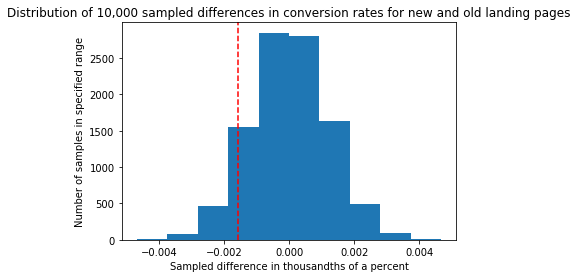

In [27]:
# Histogram to visualize the distribution from the cell above
plt.hist(p_diffs2)
plt.axvline(x=difference_in_conversion_rates, color='red', linestyle='--')
plt.title("Distribution of 10,000 sampled differences in conversion rates for new and old landing pages")
plt.xlabel('Sampled difference in thousandths of a percent')
plt.ylabel('Number of samples in specified range')

In [28]:
# What proportion of the p_diffs are greater than the actual difference observed in the df2 data?

#loop to get p_diff > observed difference values. Probably could be done a little cleaner
greater_than_obs_diff_container = []
for i in range(len(p_diffs2)):
    if p_diffs2[i] > difference_in_conversion_rates:
        greater_than_obs_diff_container.append(p_diffs2[i])
#Rounded proportion of p_diff values that are greater than the actual observed difference from df2        
print(len(greater_than_obs_diff_container) / len(p_diffs2))

0.9093


### A/B Test insights:

- The value of 0.9093 calculated above is the P-value for the dataset tested. The P-value is used to represent the chance that a researcher may observe results that are as extreme as the real P-value when the null hypothesis is assumed correct. Usually the P-value is used in tandem with a type 1 error rate or 'alpha' (in this case 0.05), and these two values are then compared to conclude if the observed change is relevant or just a conincidence.

- When the P-value is less than the type 1 error rate, the data shows that the observed change may be significant and not just a fluke. Inversely, if the P-value is greater than type 1 error rate it may show that the observed statistic is not significant and may boil down to a fluke born from the random variations in sample data.

- In this case with a p-value of 0.9093, which is many degrees bigger than the type 1 error rate of 0.05, the difference in conversion rates comparitively between the new page and the old page cannot be considered significant. If the difference in conversion rates cannot be considered significant, then I have failed to reject the null hypothesis, and the old landing page is just as useful as the new one (for now).

- Interestingly, if I go back to the variable holding my difference_in_conversion_rates and switch the places of the control and treatment groups, Ie. instead of using 'treatment_coversion_rate - control_coversion_rate', using this 'control_coversion_rate - treatment_coversion_rate' the P-value dropped significantly to 0.096. Although this does still result in failure to reject the null hypothesis, it is very interesting to note. I am assuming the negative number produced in the used difference variable caused this phenomenon. 

In [29]:
# Creating variables for 

import statsmodels.api as sm

# number of conversions with the old_page
convert_old = len(df2.query('group == "control" and converted != 0'))
#control_coversion_rate

# number of conversions with the new_page
convert_new = len(df2.query('group == "treatment" and converted != 0'))
#treatment_coversion_rate

# number of individuals who were shown the old_page
n_old = N_old


# number of individuals who received new_page
n_new = N_new


/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Part 3. Regresstion Test

** The goal is to use **statsmodels** library to fit the regression model in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [31]:
# Adding new columns to hold variables

df2['intercept'] = 1
df2['ab_page'] = 0
# This one was tricky, I used this source as a reference to build this: 
#https://stackoverflow.com/questions/45470219/set-values-based-on-df-query
df2.loc[df2['group'] == 'treatment', 'ab_page'] = 1
df2.head()

user_id                   timestamp      group landing_page  converted  \
0   851104  2017-01-21 22:11:48.556739    control     old_page          0   
1   804228  2017-01-12 08:01:45.159739    control     old_page          0   
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
4   864975  2017-01-21 01:52:26.210827    control     old_page          1   

   intercept  ab_page  
0          1        0  
1          1        0  
2          1        1  
3          1        1  
4          1        0

**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [32]:
#  Using statsmodels to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 
log_regression_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
fit_log_data = log_regression_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [33]:
#Tried to use .summmary() but was getting a weird error. I found this website explaining the two ways to solve, and I chose the easier way.
#https://stackoverflow.com/questions/49814258/statsmodel-attributeerror-module-scipy-stats-has-no-attribute-chisqprob
fit_log_data.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-07-07 22:15 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

### Regression test insights:

- The P value associated with the ab_page is 0.19 when rounded up. This is a much smaller value then the ones that we initially saw in sections j and k of about .90. 
- Both hypothesis offered assumed that there was an equal chance (0.11959708724499628) that either landing page could convert the user that visited it. Which is not assumed here in the new model. 
- The P value for the ab_page is still much larger than type I error threshold of 0.05, this shows that this regression model has come to the conclusion that the difference in conversion rates is insignificant at best. The same conclusion that I arrived at in section j and k. 
- The last thing that is attributing to the difference in the P value for this model is the fact that this is using a two tailed test setup, while in secions j and k I was using a one tailed setup. Effectively the null hypothesis and the alternative hypothesis have changed from looking at is the conversion rate of P new greater than P old to is the conversion rate of P new the same as P old!

### Conclusion
- After analyzing the data from multiple angles and using multiple statistical tools, none of the analyses have shown a significant improvement in conversion rate with the new page as compared to the old page. The data suggests that the new page may even possibly be less effective in converting users than the old page. Using the best case scenario for the new page, the conversion rate would still only be equal to that of the old pages conversion rate. I also considered the impact of the users country on the conversion results, and the data shows that the user country does not significantly alter conversion rates either. Based on the data shown through the multiple tests, I cannot suggest rejecting the null hypothesis and recommend keeping the old landing page as the default for the time being. More data may being collected may lead to my conclusions being erroneous, but for the time being this is correct.
- I would like to address the limitations and potential sources of error when interpreting P-values in data analysis. P-values are commonly used as a measure of statistical significance, but they can be susceptible to misinterpretation or misapplication. Factors leik sample size, variability, and underlying assumptions can influence P-values and lead to miscalcultions.
- Furthermore, P values only provide a probabilistic analyis of the data under the assumption that the null hypothesis is true. P values do not provide direct evidence for the truth or falsehood of the null hypothesis itself. One must consider the broader context and mesh findings through additional analyses or alternative statistical methods to come to a definitve conslusion on any matter.

### Resources
##### ***Some resources I put in line as they directly helped me formulate the code in that cell. 
##### ***All resources here were used for general syntax and question clarification

- https://www.geeksforgeeks.org/
- https://knowledge.udacity.com/questions/32882
- https://knowledge.udacity.com/questions/621478
- https://pandas.pydata.org/pandas-docs/stable/index.html

In [40]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0